# Planejamento da Solução

- Qual é o Entregável?

- Reportar ao Head de Design qual é a melhor forma de pagamento: Preenchimento Manual ou Automático do formulário de dados do cartão de crétito

- Quais dados nós temos

- uid: Id do Cliente 
- Country: País do Cliente
- Gender: Gênero do Cliente
- spent: Valor monetário que o Cliente gastou
- purchases: Quantidade de Compras 
- Date:

- Group: 
    - A: Preenchimento Automático
    - B: Preenchimento Manual

- Device:
    - I: Compra feita através do site 
    - A: Compra feita através do App

# Imports

In [2]:
import pandas as pd
import seaborn as sns
import math
import statsmodels.stats.weightstats as ws
import numpy as np
from statsmodels.stats import api as sms

from scipy.stats import shapiro,mannwhitneyu, ttest_ind
from pingouin import compute_effsize



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Helper Functions

In [3]:
def analise_normalidade(base_control, base_treatment, alpha):
    stats1, pvalue1 = shapiro(base_control)
    stats2, pvalue2 = shapiro(base_treatment)

    if (alpha < pvalue1) and (alpha < pvalue2):
        return True
        
    else:
        return False

def analise_variancia(base_control, base_treatment):

    var_control = np.var(base_control)
    var_treatment = np.var(base_treatment)

    if var_control > var_treatment:
        maior_var = var_control
        menor_var = var_treatment
    else:
        maior_var = var_treatment
        menor_var = var_control

    if (maior_var/menor_var) < 4:
        return True
    else:
        return False

# Data Load

In [4]:
df = pd.read_csv('../data/ab_testing.csv')

# 1.0 Descrição dos Dados

In [5]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [6]:
df1.shape

(45883, 8)

## 1.2 Check Na

In [7]:
df1.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [8]:
df1 = df1.dropna()

## 1.3 Data Types

In [9]:
df1.dtypes

uid           int64
country      object
gender       object
spent         int64
purchases     int64
date         object
group        object
device       object
dtype: object

## 1.4 Change Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

# 2.0 EDA

In [11]:
df2 = df1.copy()

In [12]:
df2[['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


In [13]:
df2[['uid','device']].groupby('device').count().reset_index()

,device,uid
0,A,22982
1,I,22901


In [14]:
df2[['uid','country']].groupby('country').count().reset_index().sort_values('uid', ascending=False)

,country,uid
9,USA,13998
1,BRA,9009
7,MEX,5528
3,DEU,3696
8,TUR,3537
5,FRA,2842
6,GBR,2809
4,ESP,1934
2,CAN,1513
0,AUS,1017


## 2.1 Gastos por País

<Axes: xlabel='country', ylabel='spent'>

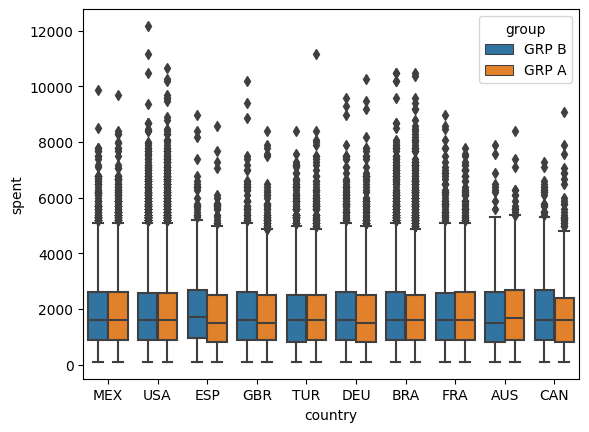

In [15]:
# Gasto por País
sns.boxplot(x=df2['country'], y=df2['spent'], hue=df2['group'])


## 2.2 Gastos por Gênero

<Axes: xlabel='gender', ylabel='spent'>

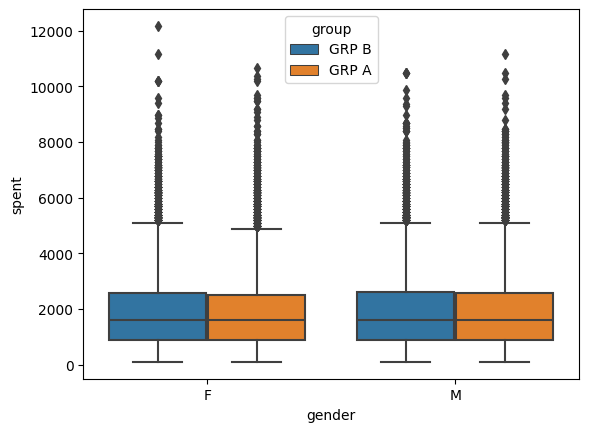

In [16]:
# Gasto por Gênero
sns.boxplot(x=df2['gender'], y=df2['spent'], hue=df2['group'])


## 2.3 Gastos por Device

<Axes: xlabel='device', ylabel='spent'>

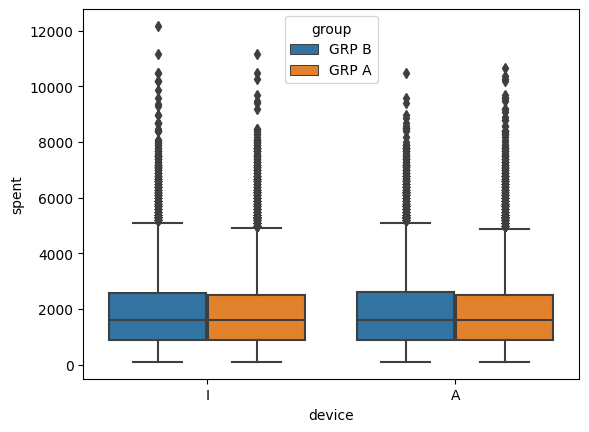

In [17]:
# Gasto por Device
sns.boxplot(x=df2['device'], y=df2['spent'], hue=df2['group'])


## 2.4 Gastos por Dia

<Axes: xlabel='date', ylabel='spent'>

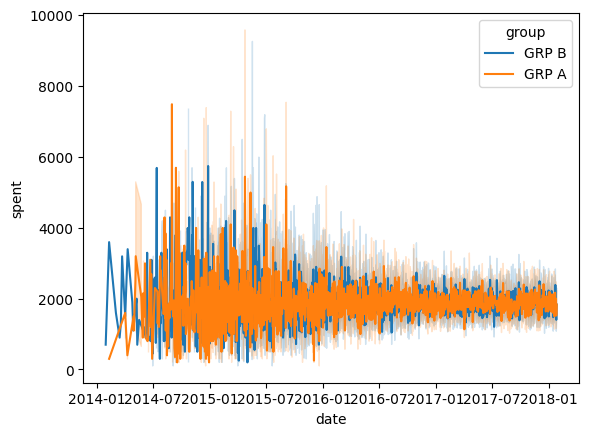

In [18]:
# Gastos por dia
sns.lineplot(x='date', y='spent',  data=df2, hue=df2['group'])

## 2.5 Gastos por Dia por Grupos

<Axes: xlabel='date', ylabel='spent'>

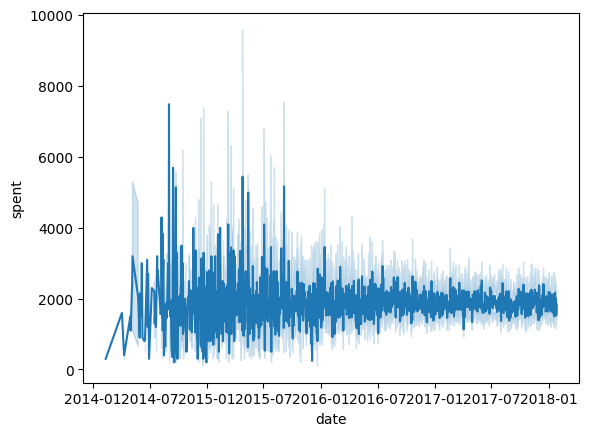

In [19]:
# Gastos por dia da página nova
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP A'])

<Axes: xlabel='date', ylabel='spent'>

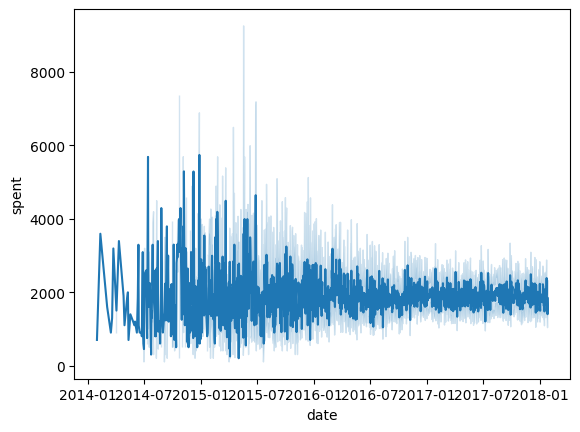

In [20]:
# Gastos por dia da página atual
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP B'])

## 2.6 Gastos por Grupos

<Axes: xlabel='group', ylabel='spent'>

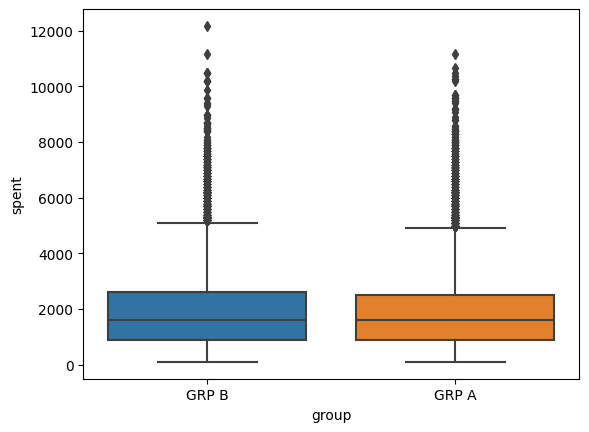

In [21]:
sns.boxplot(x=df2['group'], y=df2['spent'])

# 3.0 Design do Experimento

In [22]:
df3 = df2.copy()

## 3.1 Conferir Flags

In [23]:
df3[['uid','group']].groupby('uid').count().query('group > 1')

,group
uid,


## 3.2 Determinando Tamanho da Amostra

In [24]:
#atual_metric = media do faturamento atual
#new_metric =  O valor esperado com lift no faturamento com a nova página
results = pd.DataFrame()
paises = df3['country'].unique()
valores_lift = [0.05, 0.1, 0.11, 0.12, 0.15, 0.20]
nivel_confianca = [0.9, 0.95, 0.99]
power_stats = [0.6,0.7, 0.8, 0.9]
dict_results = {
    'Pais': [],
    'lift': [],
    'nivel_confianca': [],
    'nivel_significancia': [],
    'power_stats': [],
    'effect_size': [],
    'sample_n': [],
    'qtd_dados_disponiveis': [],
    'amostra_suficiente': []
}
for pais in paises:
    base_pais = df3[(df3['country'] == pais)]
    base_new_page = base_pais['spent'][(base_pais['group'] == 'GRP A')]
    base_current_page = base_pais['spent'][(base_pais['group'] == 'GRP B')]

    #for lift in valores_lift:
    atual_metric = base_pais['spent'].mean()
    new_metric = base_pais['spent'].mean() + ( base_pais['spent'].mean() * 0.15)
    std_metric = np.std(base_pais['spent'])

    effect_size = (new_metric - atual_metric) / std_metric

    for nv_conf in nivel_confianca:
        for pw_est in power_stats:
            sample_n = math.ceil(sms.tt_ind_solve_power(
                    effect_size,
                    power=pw_est,
                    alpha= (100-(nv_conf*100)) /100

                ))
            
            if (sample_n * 2) < base_pais.shape[0]:
                possui_dados = 'Sim'
            else:
                possui_dados = 'Não'

            dict_results = {
                'Pais': pais,
                'lift': 0.15,
                'nivel_confianca': nv_conf,
                'nivel_significancia': (100-(nv_conf*100)) /100,
                'power_stats': pw_est,
                'effect_size': effect_size,
                'sample_n': sample_n,
                'qtd_dados_disponiveis': base_new_page.shape[0] + base_current_page.shape[0],
                'amostra_suficiente': possui_dados
            }

            results = pd.concat([results, pd.DataFrame([dict_results])], ignore_index=True)
             

        

# Amostragem Aleatória dos Grupos de Tratamento e Controle

In [25]:
df4 = df3.copy()
possiveis_analises = results[results['amostra_suficiente'] == 'Sim']

# Análise por País

In [26]:
params_test_hipotese = {
    'Pais': [],
    'lift': [],
    'nivel_confianca': [],
    'nivel_significancia': [],
    'power_stats': [],
    'effect_size': [],
    'sample_n': [],
    'qtd_dados_disponiveis': [],
    'amostra_suficiente': [],
    'conversao_atual': [],
    'conversao_nova': [],
    'medias_diferentes': []
}

result_ab = pd.DataFrame()

for index, row in possiveis_analises.iterrows():
    df_control_esp = df4.loc[ (df4['country'] == row['Pais']) & (df4['group'] == 'GRP B')].sample(n = row['sample_n'], random_state=42)
    df_treatment_esp = df4.loc[(df4['country'] == row['Pais']) & (df4['group'] == 'GRP A')].sample(n = row['sample_n'], random_state=42)
    df_ab_esp = pd.concat([df_control_esp,df_treatment_esp], axis=1)

    base_control = df_control_esp['spent']
    base_treatment = df_treatment_esp['spent']

    conversao_control = base_control.mean()
    conversao_treatment = df_treatment_esp['spent'].mean()

    if analise_normalidade(base_control, base_treatment, row['nivel_significancia']) and analise_variancia(base_control, base_treatment):
            #Aplicamos T-TEST
            stats, pvalue = ttest_ind(base_control, base_treatment)

            if row['nivel_significancia'] < pvalue:
                medias_diferentes = 'Não'
                #print('As médias das duas páginas são iguais')
            else:
                medias_diferentes = 'Sim'
                #print('As médias das duas páginas não são iguais')    
    else:
        stats, pvalue = mannwhitneyu(base_control, base_treatment)

        if row['nivel_significancia'] < pvalue:
            medias_diferentes = 'Não'
            #print('As médias das duas páginas são iguais')
        else:
            medias_diferentes = 'Sim'
            #print('As médias das duas páginas não são iguais')

    params_test_hipotese = {
        'Pais': row['Pais'],
        'lift': row['lift'],
        'nivel_confianca': row['nivel_confianca'],
        'nivel_significancia': row['nivel_significancia'],
        'power_stats': row['power_stats'],
        'effect_size': row['effect_size'],
        'sample_n': row['sample_n'],
        'qtd_dados_disponiveis': row['qtd_dados_disponiveis'],
        'amostra_suficiente': row['amostra_suficiente'],
        'conversao_atual': conversao_control,
        'conversao_nova': conversao_treatment,
        'medias_diferentes': medias_diferentes
    }

    result_ab = pd.concat([result_ab, pd.DataFrame([params_test_hipotese])], ignore_index=True)

In [27]:
result_ab[result_ab['medias_diferentes'] == 'Sim']

,Pais,lift,nivel_confianca,nivel_significancia,power_stats,effect_size,sample_n,qtd_dados_disponiveis,amostra_suficiente,conversao_atual,conversao_nova,medias_diferentes
2,MEX,0.15,0.90,0.10,0.8,0.209519,283,5528,Sim,1793.533569,1901.385159,Sim
3,MEX,0.15,0.90,0.10,0.9,0.209519,391,5528,Sim,1835.222506,1916.332481,Sim
27,ESP,0.15,0.90,0.10,0.9,0.215436,370,1934,Sim,1974.624324,1804.186486,Sim
31,ESP,0.15,0.95,0.05,0.9,0.215436,454,1934,Sim,2006.116740,1814.072687,Sim
38,GBR,0.15,0.90,0.10,0.8,0.208699,285,2809,Sim,1919.350877,1769.796491,Sim
39,GBR,0.15,0.90,0.10,0.9,0.208699,394,2809,Sim,1924.385787,1767.548223,Sim
85,FRA,0.15,0.90,0.10,0.7,0.207432,220,2842,Sim,2030.159091,1777.550000,Sim
86,FRA,0.15,0.90,0.10,0.8,0.207432,289,2842,Sim,2013.889273,1819.844291,Sim
99,AUS,0.15,0.90,0.10,0.9,0.207223,400,1017,Sim,1815.602500,1973.002500,Sim


# Report para Negócio

In [28]:
df5 = df4.copy()
df5['date'] = pd.to_datetime(df5['date']).apply(lambda x: x.strftime('%Y-%m-%d'))

## México

In [44]:
faturamento_atual = df5['spent'][df5['country'] == 'MEX'].sum()
faturamento_new_page = faturamento_atual + (0.15* faturamento_atual)

print('A página Atual no México tem faturamento de: $ {}'.format(faturamento_atual))
print('A nova página no México tem o potencial de aumentar em 15% o faturamento atual, sendo ele: ${}'.format(faturamento_new_page))

aumento_mexico = np.ceil(faturamento_new_page-faturamento_atual)

print('A mudança da nova página tem a capacidade de gerar um aumento de $ {} na receita atual'.format(aumento_mexico))

A página Atual no México tem faturamento de: $ 10465336
A nova página no México tem o potencial de aumentar em 15% o faturamento atual, sendo ele: $12035136.4
A mudança da nova página tem a capacidade de gerar um aumento de $ 1569801.0 na receita atual


## Austria

In [45]:
faturamento_atual = df5['spent'][df5['country'] == 'AUS'].sum()
faturamento_new_page = faturamento_atual + (0.15* faturamento_atual)

print('A página Atual na Austria tem faturamento de: $ {}'.format(faturamento_atual))
print('A nova página na Austria tem o potencial de aumentar em 15% o faturamento atual, sendo ele: ${}'.format(faturamento_new_page))

aumento_austria = np.ceil(faturamento_new_page-faturamento_atual)

print('A mudança da nova página tem a capacidade de gerar um aumento de $ {} na receita atual'.format(aumento_austria))

A página Atual na Austria tem faturamento de: $ 1916778
A nova página na Austria tem o potencial de aumentar em 15% o faturamento atual, sendo ele: $2204294.7
A mudança da nova página tem a capacidade de gerar um aumento de $ 287517.0 na receita atual


In [48]:
aumento_receita = aumento_mexico + aumento_austria
print('Portanto, ao mudar a página nesses dois países aumentaríamos a receita da empresa em : ${}'.format(aumento_receita))

Portanto, ao mudar a página nesses dois países aumentaríamos a receita da empresa em : $1857318.0


- Os Países ESP, GBR e FRA demonstram que não é recomendado a aplicação da nova página, pois performaram pior do que a página atual